In [656]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

<ipython-input-657-de66bb0fd666>:2: DeprecationWarning: This function is deprecated. Please call randint(0, 60000 + 1) instead
  start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]


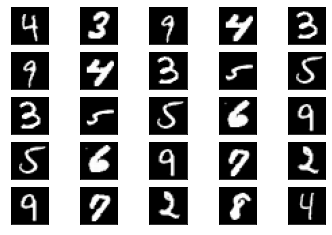

In [657]:
side = 5
start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]
fig, ax = plt.subplots(side, side)
for a in range(side):
    for b in range(side):
        ax[a, b].axes.xaxis.set_visible(False)
        ax[a, b].axes.yaxis.set_visible(False)
        ax[a, b].imshow(x_train[2 * a + b + start, :, :], cmap='gray')
plt.show()

In [658]:
print("x_train:", x_train.shape)
x_train = x_train.reshape(x_train.shape[0], -1).T # flatten
print("x_train flatten:", x_train.shape)

print("y_train:", y_train.shape)
y_train = y_train.reshape(y_train.shape[0],1).T # reshape
print("y_train:", y_train.shape)

x_train: (60000, 28, 28)
x_train flatten: (784, 60000)
y_train: (60000,)
y_train: (1, 60000)


## Code

## Import

In [659]:
import numpy as np

## Normalization

In [660]:
x_train = x_train/255
x_test = x_test/255

## initialize_parameters

In [661]:
def initialize_parameters(layers_dims):
    parameters = {}
    L = len(layers_dims) - 1
        
    for l in range(1, L+1):
        parameters['W'+str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2./layers_dims[l-1])
        parameters['b'+str(l)] = np.ones((layers_dims[l], 1))
    
    return parameters

## activation_funtion

In [662]:
def activation_funtion(Z, activation):
    if activation == "relu":
        return np.maximum(np.zeros(1), Z)
        
    if activation == "sigmoid":
        return 1 / (1 + np.exp(-Z))
    
    return Z

## forward_propagation

In [663]:
def forward_propagation(X, parameters, activation):
    cache = {}
    L = len(parameters) // 2
    cache['A0'] = X
    
    for l in range(1,L):
        cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
        cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])

    l += 1
    
    cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
    cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])
    
    return cache

## compute_cost

In [664]:
def compute_cost(AL,Y, loss = "cross_entropy"):
    m = Y.shape[1]
    
    AL = AL.T
    if loss == "cross_entropy":
        epsilon = 1e-7
        cost = -(1/m) * np.sum(np.multiply(np.log(AL + epsilon), Y) + np.multiply(np.log(1-AL + epsilon), 1-Y))
        return np.squeeze(cost)


In [665]:
def activation_derivative(Z, activation):
    if activation == "relu":
        dZ = np.ones(Z.shape)
        return (dZ >= 0).astype(int)
        
    if activation == "sigmoid":
        return np.multiply(activation_funtion(Z, "sigmoid"), (1- activation_funtion(Z, "sigmoid")))
    
    return Z

## back_propagation

In [666]:
def back_propagation(X, Y, parameters, cache, activation):
    grads = {}
    L = len(parameters) // 2
    m = Y.shape[1]
    
    grads["dZ" + str(L)] = cache['A' + str(L)] - Y
    grads["dW" + str(L)] = (1/m) * np.dot(grads["dZ" + str(L)], cache['A' + str(L-1)].T)
    grads["db" + str(L)] = (1/m) * np.sum(grads["dZ" + str(L)], axis= 1, keepdims= True)
    
    for l in range(L-1,1,-1):
        grads["dZ" + str(l)] = np.multiply(np.dot(parameters["W" + str(l+1)].T, grads["dZ" + str(l+1)]), activation_derivative(cache["Z" + str(l)],activation[l-1]))        
        grads["dW" + str(l)] = (1/m) * np.dot(grads["dZ" + str(l)], cache['A' + str(l-1)].T)
        grads["db" + str(l)] = (1/m) * np.sum(grads["dZ" + str(l)], axis= 1, keepdims= True)
    l -= 1
    
    grads["dZ" + str(l)] = np.multiply(np.dot(parameters["W" + str(l+1)].T, grads["dZ" + str(l+1)]), activation_derivative(cache["Z" + str(l)],activation[l-1]))
    grads["dW" + str(l)] = (1/m) * np.dot(grads["dZ" + str(l)], cache['A' + str(l-1)].T)
    grads["db" + str(l)] = (1/m) * np.sum(grads["dZ" + str(l)], axis= 1, keepdims= True)
    
    return grads

## update_parameters

In [667]:
def update_parameters(grads, paramaters, lr=0.01):
    
    L = len(parameters) // 2
    
    for l in range(1, L+1):
        parameters['W'+str(l)] = parameters['W'+str(l)] - np.multiply(grads['dW'+str(l)], lr)
        parameters['b'+str(l)] = parameters['b'+str(l)] - np.multiply(grads['db'+str(l)], lr)
    
    return parameters

## prediction

In [668]:
def prediction(X, Y, parameters, activation):
    cache = forward_propagation(X, parameters, activation)
    
    cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, Y)
    
    pred = cache['A' + str(len(parameters) // 2)] - Y
    
    print(pred)
    
    return "train cost: " + str(cost)

In [669]:
layers_dims = [x_train.shape[0],64,64,10]
activation = ["relu","relu","sigmoid"]
# loss_funtion = "cross_entropy"

print(x_train.shape)
print(y_train.shape)

parameters = initialize_parameters(layers_dims)

iter = 100

for i in range(iter):
    cache = forward_propagation(x_train, parameters, activation)

    cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, y_train)
    if i % 10 == 0:
        print(cost)
    grads = back_propagation(x_train, y_train, parameters, cache, activation)

    parameters = update_parameters(grads, parameters, 0.00000001)

print(parameters)


(784, 60000)
(1, 60000)
3466.9554377825702
3467.095839870175
3467.236249115435


KeyboardInterrupt: 

In [673]:
layers_dims = [32,18,7,4] # 3NN
activation = ["relu","relu","sigmoid"] # 3 Activation to 3NN
# loss_funtion = "cross_entropy"

X = np.random.randn(layers_dims[0],15) * 10
Y = np.array([[0, 1, 0.2, 0.5, 0.2, 0, 1, 0.2, 0.5, 0.2, 0, 1, 0.2, 0.5, 0.2]])

parameters = initialize_parameters(layers_dims)

iter = 1500

for i in range(iter):
    cache = forward_propagation(X, parameters, activation)

    cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, Y)
    if i % 10 == 0:
        print(cost)
    grads = back_propagation(X, Y, parameters, cache, activation)

    parameters = update_parameters(grads, parameters, 0.02)

print(parameters)


18.2112057040291
2.273822829612793
3.7256193024337336
2.142895430593697
1.657913045125398
1.8217244621278932
1.7323294378594543
1.5334805886885332
1.4723907240993586
1.639188591300125
1.4791081759287583
1.518477027504559
1.4754055850057097
1.4598718097769758
1.4449943257640718
1.4334267723664444
1.4244527497655406
1.4221551493009097
1.4150629923014848
1.4022782355223462
1.4106739244703446
1.3838563763422034
1.403247888334634
1.3822186769084932
1.4368469971215163
1.4082830109529405
1.4306006056016451
1.3755520752233408
1.385464853472805
1.4050944070229732
1.407113637556423
1.426255040447813
1.3954022322740385
1.4076639077539663
1.3955613302796612
1.4170358775574712
1.3920759331069479
1.4069183041733826
1.3901602606541634
1.4041416672136768
1.387831561130014
1.395866908495911
1.3883254368017213
1.3903812773186206
1.3810586988479465
1.390974111469701
1.379258188820665
1.3843412443047887
1.38325431276056
1.3854579459729914
1.3788529679901915
1.3791029313402752
1.374222761686774
1.381426724